In [1]:
import matplotlib.pyplot as plt
from jax.random import PRNGKey, split
import jax.numpy as jnp
import jax

from tqdm import tqdm

from jax import config
config.update("jax_enable_x64", True)

from data import generate_data
from loss import create_loss
from network import init_net, compute_end_to_end, compute_factor, compress_network
from solver import train
from utils import compose, svd
from plot import interpolate_points

In [2]:
key = PRNGKey(0)

# Simulated Data
d = 1000
r = 10

key, subkey = split(key)
target = generate_data(key=subkey, shape=(d, d), rank=r)

loss_fn = create_loss(target)
loss_fn_dict = {
    'train': loss_fn
}
network_fn = compute_end_to_end

In [3]:
depth = 3
init_scale = 1e-3

key, subkey = split(key)
init_weights = init_net(
    key=subkey, 
    input_dim=d, 
    output_dim=d, 
    width=d, 
    depth=depth, 
    init_scale=init_scale
)

tol = 1e-10
step_size = 1e3
n_outer_loops = 5000
n_inner_loops = 200

In [4]:
orig_result = train(
    init_weights=init_weights,
    network_fn=network_fn,
    loss_fn_dict=loss_fn_dict,
    n_outer_loops=n_outer_loops,
    step_size=step_size,
    tol=tol,
    n_inner_loops=n_inner_loops,
    save_weights=True
)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [5]:
V = compute_factor(init_weights=init_weights, network_fn=network_fn, loss_fn=loss_fn, grad_rank=r)
comp_init_weights = compress_network(init_weights=init_weights, V=V, grad_rank=r)

In [9]:
dlr = 0
comp_result = train(
    init_weights=comp_init_weights,
    network_fn=network_fn,
    loss_fn_dict=loss_fn_dict,
    n_outer_loops=n_outer_loops,
    step_size=step_size,
    dlr=dlr,
    tol=tol,
    n_inner_loops=n_inner_loops,
    save_weights=True
)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [10]:
orig_weights = orig_result['weights'][-10:]
comp_weights = comp_result['weights'][-10:]
orig_end_to_end = jnp.array([compute_end_to_end(w).reshape(-1) for w in orig_weights]).T
comp_end_to_end = jnp.array([compute_end_to_end(w).reshape(-1) for w in comp_weights]).T

In [11]:
A = svd(orig_end_to_end, full_matrices=False)[0][:, [7, 8, 9]].T
red_orig_end_to_end = jnp.array([A @ orig_end_to_end[:, i] for i in range(orig_end_to_end.shape[1])])
red_comp_end_to_end = jnp.array([A @ comp_end_to_end[:, i] for i in range(comp_end_to_end.shape[1])])
red_orig_end_to_end = interpolate_points(red_orig_end_to_end)
red_comp_end_to_end = interpolate_points(red_comp_end_to_end)

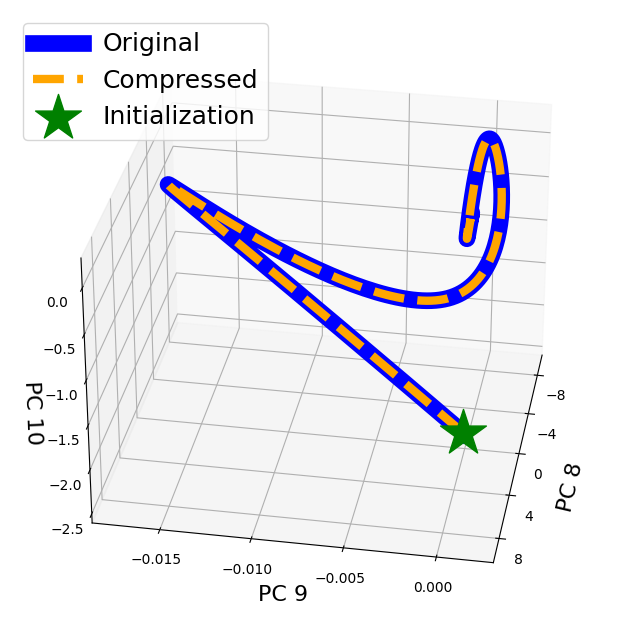

In [12]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection='3d')
ax.plot(red_orig_end_to_end[:, 0], red_orig_end_to_end[:, 1], red_orig_end_to_end[:, 2], linewidth=12, c='blue', linestyle='-', label='Original')
ax.plot(red_comp_end_to_end[:, 0], red_comp_end_to_end[:, 1], red_comp_end_to_end[:, 2], linewidth=6, c='orange', linestyle='--', label='Compressed')
ax.scatter(red_comp_end_to_end[0, 0], red_comp_end_to_end[0, 1], red_comp_end_to_end[0, 2], s=1200, c='green', marker='*', label='Initialization')
elev = 30
azim = 10
roll = 0

ax.legend(fontsize=18)

ax.set_box_aspect(None, zoom=1)

# ax.xaxis.set_major_formatter(ticker.MultipleLocator(20))
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
ax.xaxis.set_major_locator(MultipleLocator(4))
ax.yaxis.set_major_locator(MultipleLocator(0.005))
# ax.zaxis.set_major_locator(MultipleLocator(1))

ax.set_xlabel('\nPC 8', fontsize=16)
ax.set_ylabel('PC 9', fontsize=16)
ax.set_zlabel('PC 10', fontsize=16)
ax.view_init(elev, azim, roll)

plt.savefig('figs/equiv_traj_l2_left.png', dpi=300, bbox_inches='tight')

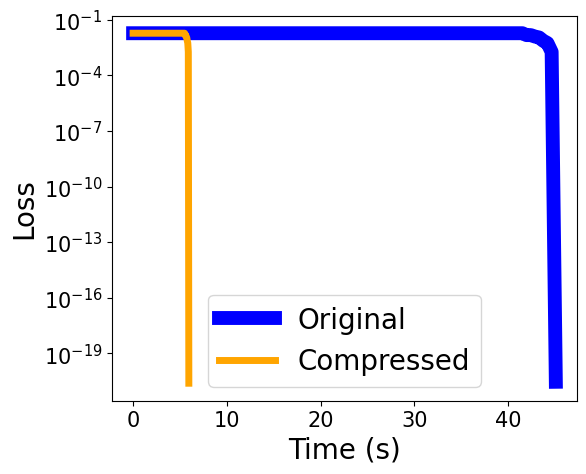

In [13]:
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot()

ax.semilogy(orig_result['time'], orig_result['train_loss'], linewidth=10, c='blue', label='Original')
ax.semilogy(comp_result['time'], comp_result['train_loss'], linewidth=5, c='orange', label='Compressed')
ax.set_xlabel('Time (s)', fontsize=20)
ax.set_ylabel('Loss', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.legend(fontsize=20)

plt.savefig('figs/equiv_traj_l2_right.png', dpi=300, bbox_inches='tight')

In [14]:
from PIL import Image

image1 = Image.open('figs/equiv_traj_l2_left.png')
image2 = Image.open('figs/equiv_traj_l2_right.png')

(width1, height1) = image1.size
(width2, height2) = image2.size

ratio = height1 / height2

image2 = image2.resize(size=(int(width2 * ratio), int(height2 * ratio)))
(width2, height2) = image2.size

result_width = width1 + width2
result_height = height1

result = Image.new('RGB', (result_width, result_height))
result.paste(im=image1, box=(0, 0))
result.paste(im=image2, box=(width1, 0))

result.save('figs/equiv_traj_l2.png')

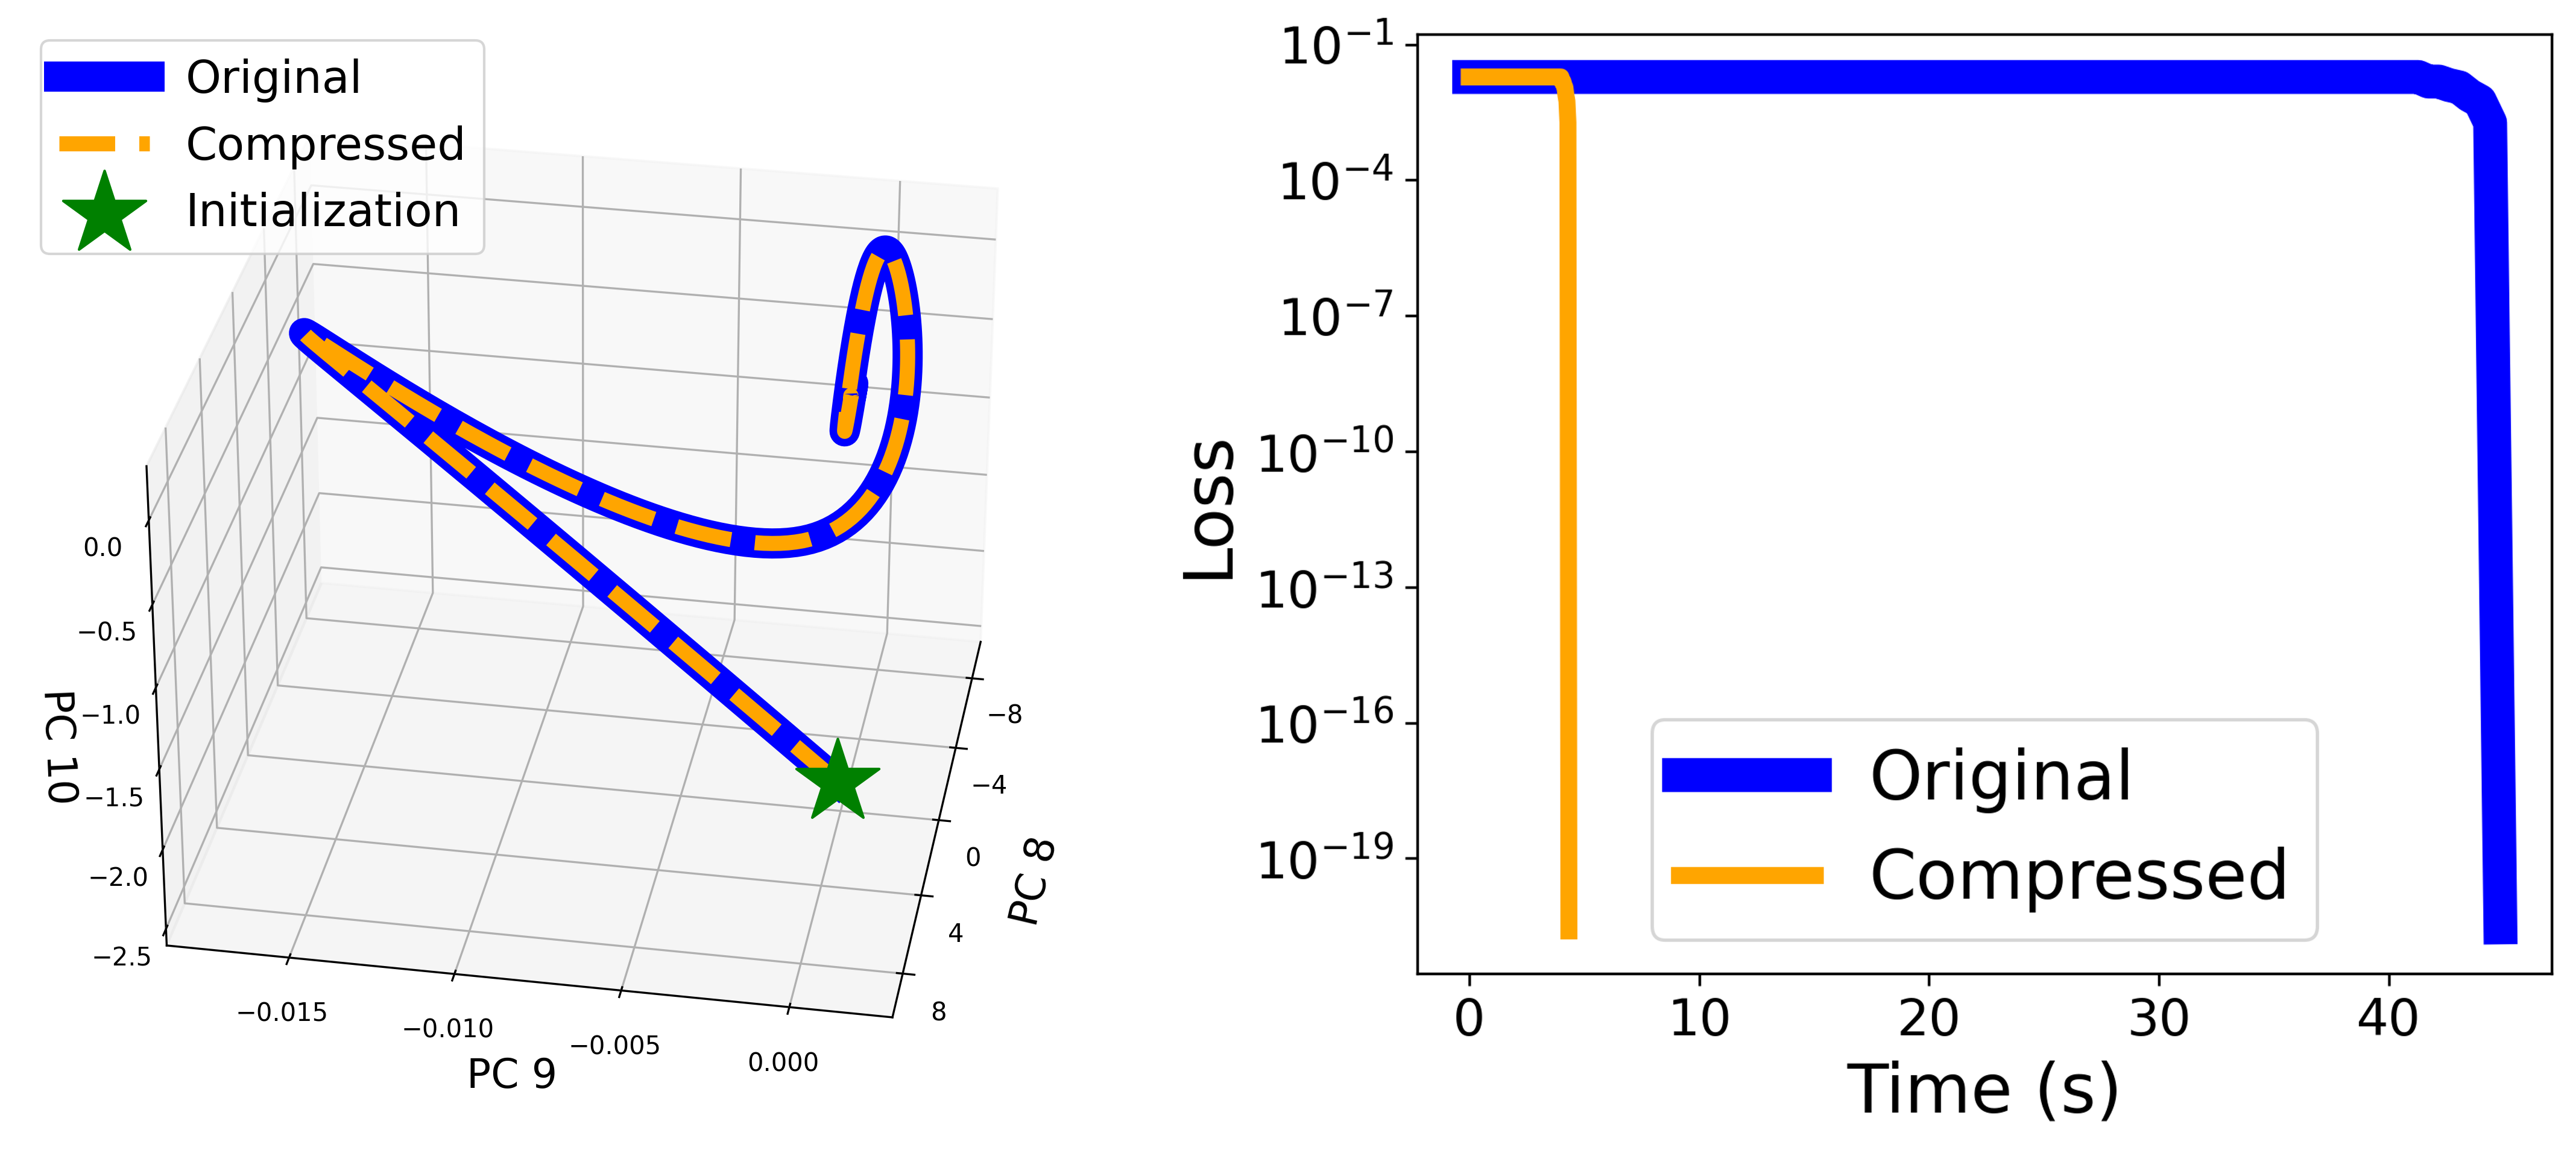

In [15]:
result